In [1]:
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df = pd.read_csv('../data/stroke_prediction_dataset.csv')

In [42]:
print('Shape of dataset:', df.shape)
print('First 15 rows:')
display(df.head(15))

Shape of dataset: (5110, 12)
First 15 rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [5]:
df = df.drop(columns=['id'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
None


In [6]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [7]:
# Data Preprocessing & Feature Engineering

In [8]:
# Count missing values in the problematic features
missing_analysis = pd.DataFrame({
    'feature': ['bmi', 'gender', 'smoking_status'],
    'total_missing': [
        df['bmi'].isna().sum(),
        (df['gender'] == 'Other').sum(),
        (df['smoking_status'] == 'Unknown').sum()
    ],
    'missing_percentage': [
        (df['bmi'].isna().sum() / len(df)) * 100,
        ((df['gender'] == 'Other').sum() / len(df)) * 100,
        ((df['smoking_status'] == 'Unknown').sum() / len(df)) * 100
    ]
})

print('Missing Value Analysis:')
print(missing_analysis)

Missing Value Analysis:
          feature  total_missing  missing_percentage
0             bmi            201            3.933464
1          gender              1            0.019569
2  smoking_status           1544           30.215264


In [9]:
from sklearn.impute import KNNImputer
def clean_stroke_data(df):
    '''
    Comprehensive cleaning function for Stroke dataset
    '''
    # Make a copy to avoid modifying original
    df_clean = df.copy()
    df_clean = df_clean.rename(columns={'gender': 'sex'})
    
    # Step 1: Drop high-missing columns
    # Dropping ever_married and Residence_type features because their clinical / practical relevance for stroke prediction is questionable
    columns_to_drop = ['smoking_status', 'ever_married', 'Residence_type']
    df_clean = df_clean.drop(columns=columns_to_drop, errors='ignore')
    
    # Step 2: Clean column names
    df_clean.columns = df_clean.columns.str.strip()
    
    # Step 3: Handle any minor missing values
    df_clean = df_clean[~(df_clean['sex'] == 'Other')]
    
    # Step 4: Convert numerical columns to proper numeric type
    df_clean['age'] = df_clean['age'].astype(int)
    df_clean['hypertension'] = df_clean['hypertension'].astype(int)
    df_clean['heart_disease'] = df_clean['heart_disease'].astype(int)
    df['avg_glucose_level'] = df['avg_glucose_level'].astype(float)
    df['bmi'] = df['bmi'].astype(float)
    
    
    # Step 5: Convert categorical columns (handle any remaining '?')
    df_clean['sex'] = df_clean['sex'].map({'Male': 1, 'Female': 0})
    wt_map = {
        'Private':       0,
        'Self-employed': 1,
        'Govt_job':      2,
        'children':      3,
        'Never_worked':  4
    }
    df_clean['work_type'] = df_clean['work_type'].map(wt_map).astype(int)

    # Step 6: Impute missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)
    
    # Step 7: Drop rows with any remaining missing values
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna()
    final_rows = len(df_clean)
    
    print(f'  Data cleaning completed:')
    print(f'  Rows removed due to missing values: {initial_rows - final_rows}')
    print(f'  Final dataset shape: {df_clean.shape}')
    
    # Step 8: Create binary target
    df_clean['stroke'] = (df_clean['stroke'] > 0).astype(int)
    
    return df_clean

# Apply the comprehensive cleaning
df_clean = clean_stroke_data(df)

# Verify no more 'NaN' values
print('  Verification - No more missing values:')

for col in df_clean.columns:
    if (df_clean[col].isna()).any():
        print(f'  WARNING: Still found NaN in {col}')
    else:
        print(f'  {col}: Clean')

  Data cleaning completed:
  Rows removed due to missing values: 0
  Final dataset shape: (5109, 8)
  Verification - No more missing values:
  sex: Clean
  age: Clean
  hypertension: Clean
  heart_disease: Clean
  work_type: Clean
  avg_glucose_level: Clean
  bmi: Clean
  stroke: Clean


In [10]:
print('Final Clean Dataset:')
print(f'Shape: {df_clean.shape}')
print(f'Columns: {df_clean.columns.tolist()}')

Final Clean Dataset:
Shape: (5109, 8)
Columns: ['sex', 'age', 'hypertension', 'heart_disease', 'work_type', 'avg_glucose_level', 'bmi', 'stroke']


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [12]:
print('Target Distribution:')
print(df_clean['stroke'].value_counts())
print(f'Baseline accuracy: {max(df_clean['stroke'].value_counts(normalize=True)):.3f}')

Target Distribution:
stroke
0    4860
1     249
Name: count, dtype: int64
Baseline accuracy: 0.951


In [13]:
# The dataset is highly imbalanced, so accuracy is misleading.
# F1-score is used instead because it better reflects performance on the minority (stroke) class.


# Separate features and target
X = df_clean.drop(['stroke'], axis=1)
y = df_clean['stroke']

# Split the data
X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f' Dataset Split:')
print(f'Training set: {X_train_imbalanced.shape}')
print(f'Test set: {X_test.shape}')

 Dataset Split:
Training set: (4087, 7)
Test set: (1022, 7)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=13, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=13, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=13),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=13),
    'SVM': SVC(kernel='linear', random_state=13, class_weight='balanced', probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=13, class_weight='balanced')
}

In [22]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
# scoring = make_scorer(f1_score)
scoring = 'recall'

# Since the dataset is imbalanced (stroke cases are rare),
# we can use SMOTE to oversample the minority class and improve model learning.
from imblearn.over_sampling import SMOTE

# Create pipelines with SMOTE and scaling, 
scaling_models = ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']
model_pipelines = {}
for name, model in models.items():
    steps = []
    
    # add SMOTE
    steps.append(('smote', SMOTE()))
    
    # add scaler for models that need it
    if name in scaling_models:
        steps.append(('scaler', StandardScaler()))
    
    # add classifier
    steps.append(('classifier', model))
    
    pipeline = Pipeline(steps)
    model_pipelines[name] = pipeline
    

# Perform cross-validation for each model
cv_results = {}
print(' Running 5-Fold Cross-Validation...')
for name, model in model_pipelines.items():
    try:
        cv_scores = cross_val_score(
            model,
            X_train_imbalanced,
            y_train_imbalanced,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        cv_results[name] = {
            'mean_score': cv_scores.mean(),
            'std': cv_scores.std(),
            'all_scores': cv_scores
        }
        print(f'✅ {name:25s}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
    except Exception as e:
        print(f' {name:25s}: Error - {str(e)}')
        cv_results[name] = {'mean_accuracy': 0, 'std_accuracy': 0, 'all_scores': []}

# Display results in sorted order
print(' Cross-Validation Results (Sorted by Performance):')
print('=' * 60)

sorted_results = sorted(
    cv_results.items(),
    key=lambda x: x[1]['mean_score'],
    reverse=True
)

for name, results in sorted_results:
    print(f'{name:25s}: {results['mean_score']:.4f} ± {results['std']:.4f}')

# Identify best model
best_model_name = sorted_results[0][0]
best_cv_score = sorted_results[0][1]['mean_score']
print(f' Best Model: {best_model_name} (CV recall: {best_cv_score:.4f})')

 Running 5-Fold Cross-Validation...
✅ Logistic Regression      : 0.7790 ± 0.0285
✅ Random Forest            : 0.0753 ± 0.0221
✅ Gradient Boosting        : 0.0806 ± 0.0375
✅ AdaBoost                 : 0.1756 ± 0.0565
✅ SVM                      : 0.7841 ± 0.0398
✅ K-Nearest Neighbors      : 0.2912 ± 0.0317
✅ Extra Trees              : 0.0753 ± 0.0221
 Cross-Validation Results (Sorted by Performance):
SVM                      : 0.7841 ± 0.0398
Logistic Regression      : 0.7790 ± 0.0285
K-Nearest Neighbors      : 0.2912 ± 0.0317
AdaBoost                 : 0.1756 ± 0.0565
Gradient Boosting        : 0.0806 ± 0.0375
Random Forest            : 0.0753 ± 0.0221
Extra Trees              : 0.0753 ± 0.0221
 Best Model: SVM (CV recall: 0.7841)


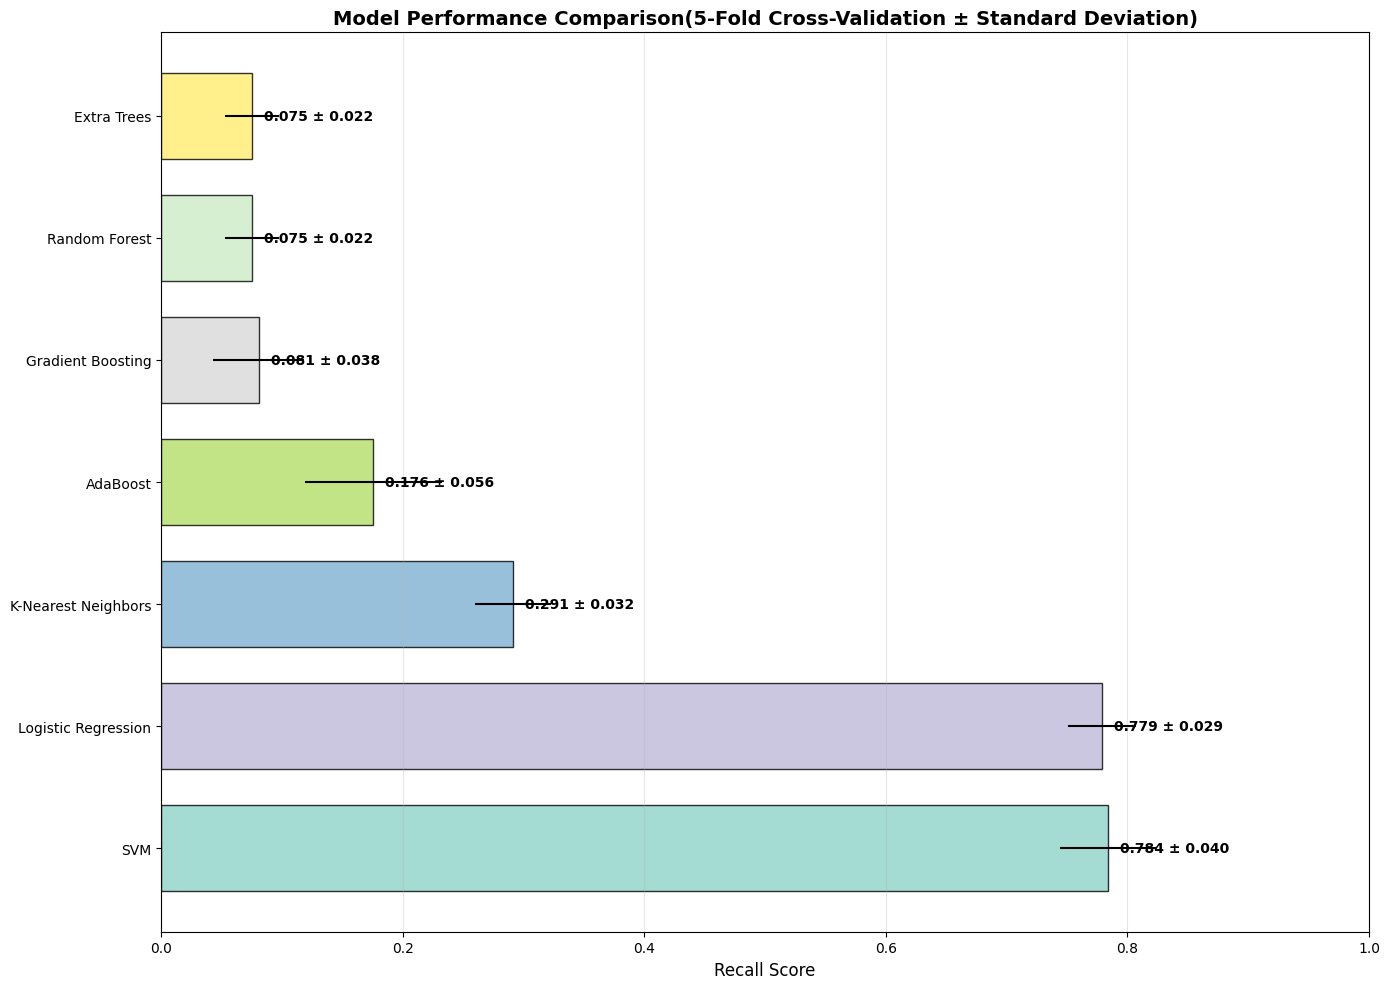

 Detailed CV Scores for SVM:
  Fold 1: 0.7500
  Fold 2: 0.8250
  Fold 3: 0.8205
  Fold 4: 0.8000
  Fold 5: 0.7250


In [23]:
# Create visualization of model performance
plt.figure(figsize=(14, 10))
model_names = [name for name, _ in sorted_results]
mean_scores = [results['mean_score'] for _, results in sorted_results]
std_scores = [results['std'] for _, results in sorted_results]

colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
bars = plt.barh(range(len(model_names)), mean_scores, xerr=std_scores, 
                alpha=0.8, color=colors, edgecolor='black', height=0.7)

plt.yticks(range(len(model_names)), model_names)
plt.xlabel('Recall Score', fontsize=12)
plt.title('Model Performance Comparison(5-Fold Cross-Validation ± Standard Deviation)', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (mean, std) in enumerate(zip(mean_scores, std_scores)):
    plt.text(mean + 0.01, i, f'{mean:.3f} ± {std:.3f}', 
             va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Show individual fold scores for the best model
print(f' Detailed CV Scores for {best_model_name}:')
best_scores = cv_results[best_model_name]['all_scores']
for fold, score in enumerate(best_scores, 1):
    print(f'  Fold {fold}: {score:.4f}')

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# find best params for logistic regression
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=500))
])

param_grid = {
    'clf__C': [0.1, 1, 5, 10, 50],
    'clf__penalty': ['l1', 'l2'],
    'clf__class_weight': ['balanced', None]
}

grid_log = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid_log.fit(X_train_imbalanced, y_train_imbalanced)

print('Best params:', grid_log.best_params_)
print('Best score:', grid_log.best_score_)

Best params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Best score: 0.7838461538461539


In [27]:
# find best params for svm
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True))
])

param_grid = {
    'clf__kernel': ['rbf', 'linear'],
    'clf__C': [0.1, 1, 5, 10, 50],
    'clf__gamma': ['scale', 'auto']
}
grid_log = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid_log.fit(X_train_imbalanced, y_train_imbalanced)

print('Best params:', grid_log.best_params_)
print('Best score:', grid_log.best_score_)

Best params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best score: 0.7888461538461538


In [28]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

In [29]:
log_reg_best = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=0.1,
        penalty='l2',
        class_weight='balanced',
        solver='liblinear',
        max_iter=500,
        random_state=13
    ))
])

log_reg_best.fit(X_train_imbalanced, y_train_imbalanced)

,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,None
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'


In [30]:
y_pred_lr = log_reg_best.predict(X_test)
y_prob_lr = log_reg_best.predict_proba(X_test)[:,1]


print('\n=== Logistic Regression Evaluation ===')
print(f'Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_lr):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_lr):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred_lr):.4f}')
print(f'ROC AUC:   {roc_auc_score(y_test, y_prob_lr):.4f}')

print(' Detailed Classification Report:')
print(classification_report(y_test, y_pred_lr, target_names=['No Disease', 'Disease']))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lr))


=== Logistic Regression Evaluation ===
Accuracy:  0.7387
Precision: 0.1347
Recall:    0.8000
F1 Score:  0.2305
ROC AUC:   0.8389
 Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.99      0.74      0.84       972
     Disease       0.13      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022

Confusion Matrix:
[[715 257]
 [ 10  40]]


In [31]:
# probability tweaking for log_reg
y_pred_lr = log_reg_best.predict(X_test)
y_prob_lr = log_reg_best.predict_proba(X_test)[:,1]


threshold = 0.67
y_pred_lr_adj = (y_prob_lr >= threshold).astype(int)

print('\n=== Logistic Regression Evaluation ===')
print(f'Accuracy:  {accuracy_score(y_test, y_pred_lr_adj ):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_lr_adj ):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_lr_adj ):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred_lr_adj ):.4f}')
print(f'ROC AUC:   {roc_auc_score(y_test, y_pred_lr_adj ):.4f}')

print(' Detailed Classification Report:')
print(classification_report(y_test, y_pred_lr_adj, target_names=['No Disease', 'Disease']))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lr_adj))


=== Logistic Regression Evaluation ===
Accuracy:  0.8395
Precision: 0.1935
Recall:    0.7200
F1 Score:  0.3051
ROC AUC:   0.7828
 Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.98      0.85      0.91       972
     Disease       0.19      0.72      0.31        50

    accuracy                           0.84      1022
   macro avg       0.59      0.78      0.61      1022
weighted avg       0.94      0.84      0.88      1022

Confusion Matrix:
[[822 150]
 [ 14  36]]


In [32]:
svm_best = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('clf', SVC(
        C=50,
        kernel='linear',
        probability=True,
        random_state=13
    ))
])

svm_best.fit(X_train_imbalanced, y_train_imbalanced)

,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,None
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,C,50


In [33]:
y_pred_svm = svm_best.predict(X_test)
y_prob_svm = svm_best.predict_proba(X_test)[:,1]

print('\n=== SVM Evaluation ===')
print(f'Accuracy:  {accuracy_score(y_test, y_pred_svm):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_svm):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_svm):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred_svm):.4f}')
print(f'ROC AUC:   {roc_auc_score(y_test, y_pred_svm):.4f}')

print(' Detailed Classification Report:')
print(classification_report(y_test, y_pred_svm, target_names=['No Disease', 'Disease']))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))


=== SVM Evaluation ===
Accuracy:  0.7192
Precision: 0.1262
Recall:    0.8000
F1 Score:  0.2180
ROC AUC:   0.7575
 Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.99      0.72      0.83       972
     Disease       0.13      0.80      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.72      0.80      1022

Confusion Matrix:
[[695 277]
 [ 10  40]]


In [34]:
# probability tweaking for svm
y_pred_svm = svm_best.predict(X_test)
y_prob_svm = svm_best.predict_proba(X_test)[:,1]

threshold = 0.65
y_pred_svm_adj = (y_prob_svm >= threshold).astype(int)

print('\n=== SVM Evaluation ===')
print(f'Accuracy:  {accuracy_score(y_test, y_pred_svm_adj):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_svm_adj):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_svm_adj):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred_svm_adj):.4f}')
print(f'ROC AUC:   {roc_auc_score(y_test, y_pred_svm_adj):.4f}')

print(' Detailed Classification Report:')
print(classification_report(y_test, y_pred_svm_adj, target_names=['No Disease', 'Disease']))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm_adj))


=== SVM Evaluation ===
Accuracy:  0.8356
Precision: 0.1959
Recall:    0.7600
F1 Score:  0.3115
ROC AUC:   0.7998
 Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.99      0.84      0.91       972
     Disease       0.20      0.76      0.31        50

    accuracy                           0.84      1022
   macro avg       0.59      0.80      0.61      1022
weighted avg       0.95      0.84      0.88      1022

Confusion Matrix:
[[816 156]
 [ 12  38]]


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    auc,
    classification_report
)

In [36]:
def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    print(f'\n=== {name} Evaluation ===')

    # Probability (positive class)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC-AUC: {roc_auc:.4f}')

    # Thresholding
    y_pred = (y_proba >= threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} — Confusion Matrix (threshold={threshold})')
    plt.show()

    # Metrics
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, digits=4))

    # Precision–Recall & PR-AUC
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} — Precision-Recall Curve')
    plt.legend()
    plt.show()

    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }


=== Logistic Regression Evaluation ===
ROC-AUC: 0.8389


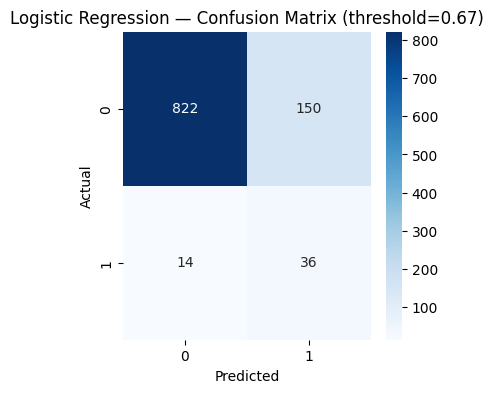


Classification Report:
              precision    recall  f1-score   support

           0     0.9833    0.8457    0.9093       972
           1     0.1935    0.7200    0.3051        50

    accuracy                         0.8395      1022
   macro avg     0.5884    0.7828    0.6072      1022
weighted avg     0.9446    0.8395    0.8797      1022



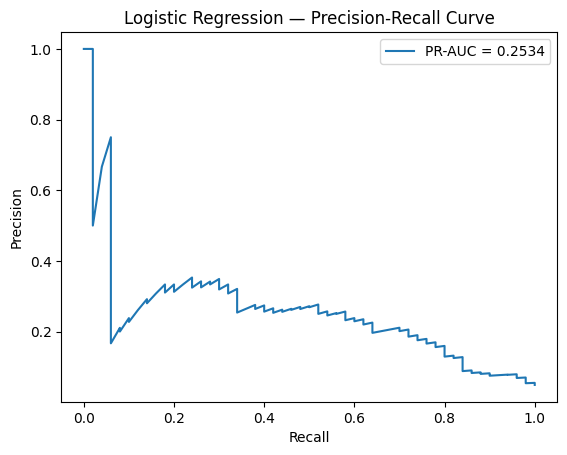

In [37]:
results_log = evaluate_model(
    name='Logistic Regression',
    model=log_reg_best,
    X_test=X_test,
    y_test=y_test,
    threshold=0.67
)


=== SVM Evaluation ===
ROC-AUC: 0.8379


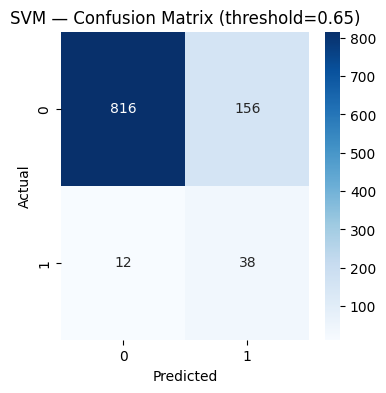


Classification Report:
              precision    recall  f1-score   support

           0     0.9855    0.8395    0.9067       972
           1     0.1959    0.7600    0.3115        50

    accuracy                         0.8356      1022
   macro avg     0.5907    0.7998    0.6091      1022
weighted avg     0.9469    0.8356    0.8775      1022



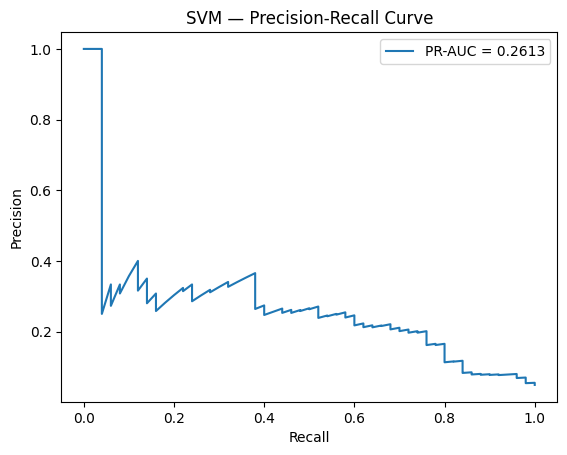

In [38]:
results_log = evaluate_model(
    name='SVM',
    model=svm_best,
    X_test=X_test,
    y_test=y_test,
    threshold=0.65
)

In [40]:
import pickle

model_path = '../trained_models/stroke-svm_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(svm_best, f)
print('Models saved successfully.')

Models saved successfully.
